체크포인트 로드 완료

처리 중: 환자 0
예측 마스크가 ./prediction_mask_00740.nii.gz에 저장되었습니다.


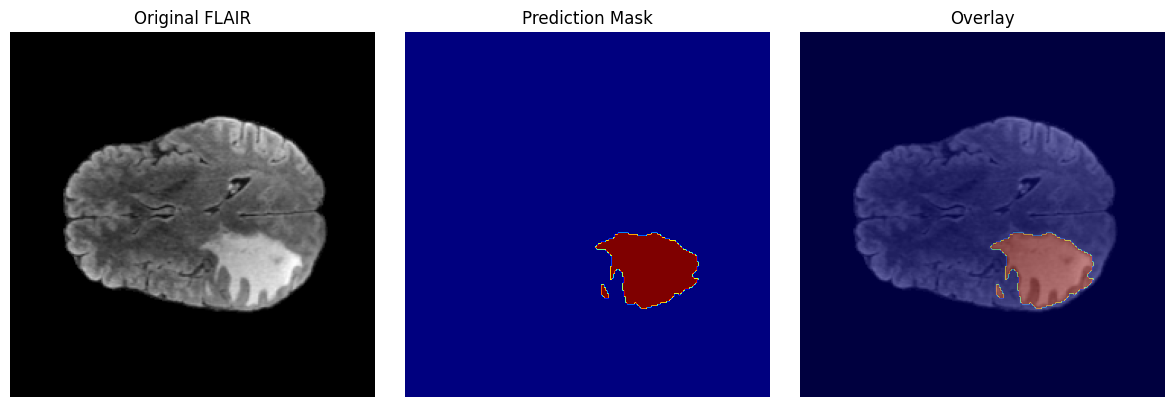

환자 00740 처리 완료

모든 예측 및 시각화가 완료되었습니다.

생성된 파일 목록:


In [2]:
from functools import partial 
import os
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from monai import transforms, data
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    AsDiscrete,
    Activations,
)

# 디바이스 설정
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# 모델 설정
roi = (128, 128, 128)
model = SwinUNETR(
    img_size=roi,
    in_channels=1,
    out_channels=1,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

# 체크포인트 로드
checkpoint_path = "/home/alpaco/cgy/swinfl.pt"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("체크포인트 로드 완료")
else:
    print("체크포인트 파일을 찾을 수 없습니다!")

# 후처리 함수 설정
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(threshold=0.5)

# sliding window inference 설정
sw_batch_size = 4
infer_overlap = 0.5

model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

def save_prediction_overlay(t1_path, prediction_array, output_path, slice_idx=None):
    """
    T1 MRI 이미지에 예측된 마스크를 이진 형태로 저장합니다.
    """
    # 원본 T1 이미지 로드
    t1_img = nib.load(t1_path)
    
    # 예측 결과를 이진 마스크로 변환 (0 또는 1)
    pred_mask = (prediction_array > 0.5).astype(np.float32)
    
    # nii 파일로 저장 (3D 형태로)
    mask_img = nib.Nifti1Image(pred_mask, t1_img.affine, t1_img.header)
    nib.save(mask_img, output_path)
    print(f"예측 마스크가 {output_path}에 저장되었습니다.")
    
    # 시각화 (선택적)
    if slice_idx is not None:
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.imshow(t1_img.get_fdata()[:, :, slice_idx], cmap='gray')
        plt.title('Original FLAIR')
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(pred_mask[:, :, slice_idx], cmap='jet')
        plt.title('Prediction Mask')
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(t1_img.get_fdata()[:, :, slice_idx], cmap='gray')
        plt.imshow(pred_mask[:, :, slice_idx], cmap='jet', alpha=0.5)
        plt.title('Overlay')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# 테스트할 환자 데이터 직접 지정
test_data = [
    {
        "image": ["/home/alpaco/cgy/BraTS2021_00740_flair.nii"]
    }
]

# 테스트용 transform 설정
test_transform = transforms.Compose([
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"]),
    transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
])

# 테스트 데이터셋과 로더 생성
test_ds = data.Dataset(data=test_data, transform=test_transform)
test_loader = data.DataLoader(test_ds, batch_size=1)

# 결과 저장 디렉토리 생성
output_dir = "/home/alpaco/cgy/740"
os.makedirs(output_dir, exist_ok=True)

# 모델을 평가 모드로 설정
model.eval()

# 각 환자별로 예측 수행
with torch.no_grad():
    for idx, batch_data in enumerate(test_loader):
        print(f"\n처리 중: 환자 {idx}")
        
        # 예측 수행
        data = batch_data["image"].to(device)
        pred = model_inferer(data)
        pred = post_sigmoid(pred)
        pred = post_pred(pred)
        pred_np = pred.cpu().numpy()
        
        # 원본 파일 경로와 출력 파일 경로
        t1_path = test_data[idx]["image"][0]
        patient_id = os.path.basename(t1_path).split('_')[1]  # BraTS2021_00000에서 00000 추출
        output_path = os.path.join("./", f"prediction_mask_{patient_id}.nii.gz")
        
        # 중간 슬라이스 계산 (시각화용)
        middle_slice = pred_np.shape[-1] // 2
        
        # 예측 결과 저장 및 시각화
        save_prediction_overlay(t1_path, pred_np[0, 0], output_path, slice_idx=middle_slice)
        
        print(f"환자 {patient_id} 처리 완료")

print("\n모든 예측 및 시각화가 완료되었습니다.")

# 처리된 파일 목록 출력
print("\n생성된 파일 목록:")
for file in sorted(os.listdir(output_dir)):
    if file.startswith("prediction_mask_"):
        print(f"- {file}")

/home/alpaco/anaconda3/envs/final_env/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


체크포인트 로드 완료

처리 중: 환자 0


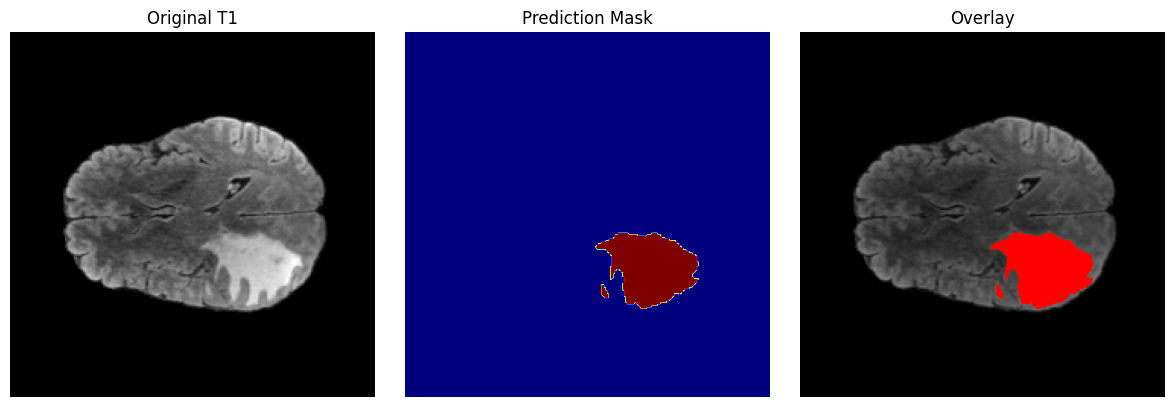

오버레이 이미지가 /home/alpaco/cgy/prediction_flair_overlay_00740.nii.gz에 저장되었습니다.
환자 00740 처리 완료

모든 예측 및 시각화가 완료되었습니다.

생성된 파일 목록:
- prediction_flair_overlay_00740.nii.gz


In [12]:
#마스크를 오버레이한 3D NIFTI 이미지를 저장하고 싶다면 하단의 코드를 실행#

from functools import partial 
import os
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from monai import transforms, data
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    AsDiscrete,
    Activations,
)

# 디바이스 설정
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# 모델 설정
roi = (128, 128, 128)
model = SwinUNETR(
    img_size=roi,
    in_channels=1,
    out_channels=1,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

# 체크포인트 로드
checkpoint_path = "/home/alpaco/cgy/swinfl.pt"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("체크포인트 로드 완료")
else:
    print("체크포인트 파일을 찾을 수 없습니다!")

# 후처리 함수 설정
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(threshold=0.5)

# sliding window inference 설정
sw_batch_size = 4
infer_overlap = 0.5

model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

def save_prediction_overlay(t1_path, prediction_array, output_path, slice_idx=None):
    """
    T1 MRI 이미지에 예측된 마스크를 오버레이하여 nii 파일로 저장합니다.
    """
    # 원본 T1 이미지 로드
    t1_img = nib.load(t1_path)
    t1_data = t1_img.get_fdata()
    
    # 차원 확인 및 조정
    if prediction_array.shape != t1_data.shape:
        raise ValueError(f"예측 마스크 shape {prediction_array.shape}가 FLAIR 이미지 shape {t1_data.shape}와 일치하지 않습니다.")
    
    # 시각화를 위해 T1 이미지 정규화 (0-1 범위로)
    t1_norm = (t1_data - t1_data.min()) / (t1_data.max() - t1_data.min())
    
    # RGB 이미지 생성 (4D: x, y, z, RGB)
    overlay = np.zeros((*t1_data.shape, 4))  # RGBA 이것때문에 처음에 아핀변환 후 AAL이 안되었었음
    
    # T1 이미지를 회색조로 설정
    overlay[..., 0] = t1_norm  # R
    overlay[..., 1] = t1_norm  # G
    overlay[..., 2] = t1_norm  # B
    overlay[..., 3] = 1.0      # A (완전 불투명)
    
    # 예측된 부분을 빨간색으로 오버레이
    mask = prediction_array > 0.5  # 이진 마스크로 변환
    overlay[mask, 0] = 1.0  # R (빨간색)
    overlay[mask, 1] = 0.0  # G
    overlay[mask, 2] = 0.0  # B
    overlay[mask, 3] = 1.0  # A
    
    # 특정 슬라이스 시각화 (디버깅용)
    if slice_idx is not None:
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.imshow(t1_norm[:, :, slice_idx], cmap='gray')
        plt.title('Original T1')
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(mask[:, :, slice_idx], cmap='jet')
        plt.title('Prediction Mask')
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(overlay[:, :, slice_idx, :3])  # RGB만 표시
        plt.title('Overlay')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # nii 파일로 저장
    overlay_img = nib.Nifti1Image(overlay, t1_img.affine, t1_img.header)
    nib.save(overlay_img, output_path)
    print(f"오버레이 이미지가 {output_path}에 저장되었습니다.")

# 테스트할 환자 데이터 직접 지정
test_data = [
    {
        "image": ["/home/alpaco/cgy/BraTS2021_00740_flair.nii"]
    },
]

# 테스트용 transform 설정
test_transform = transforms.Compose([
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"]),
    transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
])

# 테스트 데이터셋과 로더 생성
test_ds = data.Dataset(data=test_data, transform=test_transform)
test_loader = data.DataLoader(test_ds, batch_size=1)

# 결과 저장 디렉토리 생성
output_dir = "/home/alpaco/cgy/"
os.makedirs(output_dir, exist_ok=True)

# 모델을 평가 모드로 설정
model.eval()

# 각 환자별로 예측 수행
with torch.no_grad():
    for idx, batch_data in enumerate(test_loader):
        print(f"\n처리 중: 환자 {idx}")
        
        # 예측 수행
        data = batch_data["image"].to(device)
        pred = model_inferer(data)
        pred = post_sigmoid(pred)
        pred = post_pred(pred)
        pred_np = pred.cpu().numpy()
        
        # 원본 파일 경로와 출력 파일 경로
        t1_path = test_data[idx]["image"][0]
        patient_id = os.path.basename(t1_path).split('_')[1]  # BraTS2021_00000에서 00000 추출
        output_path = os.path.join(output_dir, f"prediction_flair_overlay_{patient_id}.nii.gz")
        
        # 중간 슬라이스 계산 (시각화용)
        middle_slice = pred_np.shape[-1] // 2
        
        # 예측 결과 저장 및 시각화
        save_prediction_overlay(t1_path, pred_np[0, 0], output_path, slice_idx=middle_slice)
        
        print(f"환자 {patient_id} 처리 완료")

print("\n모든 예측 및 시각화가 완료되었습니다.")

# 처리된 파일 목록 출력
print("\n생성된 파일 목록:")
for file in sorted(os.listdir(output_dir)):
    if file.startswith("prediction_flair_overlay_"):
        print(f"- {file}")

Data shape: (240, 240, 155, 4)


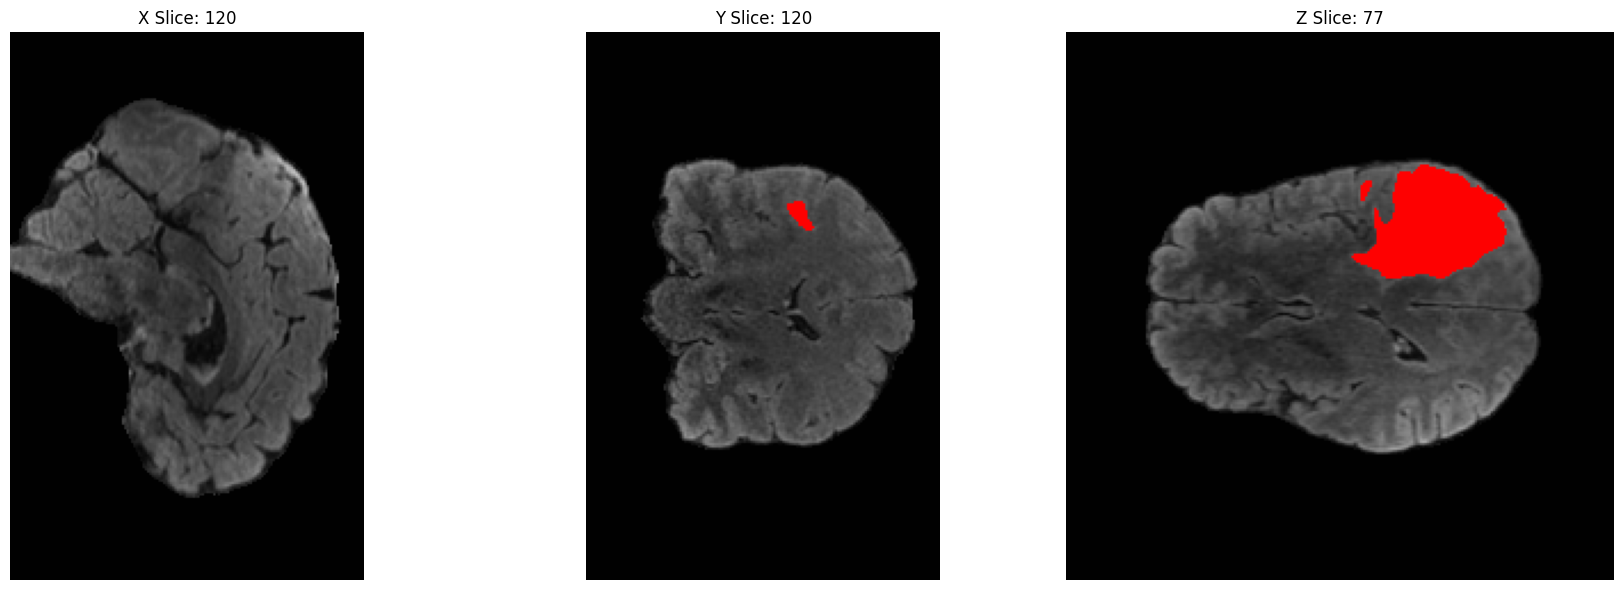

In [14]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# 파일 경로
file_path = '/home/alpaco/cgy/prediction_flair_overlay_00740.nii.gz'

# NIfTI 파일 로드
nii = nib.load(file_path)
data = nii.get_fdata()

# 데이터 확인
print(f"Data shape: {data.shape}")

# 중심 슬라이스 계산
x_slice = data.shape[0] // 2
y_slice = data.shape[1] // 2
z_slice = data.shape[2] // 2

# x, y, z 방향 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# X 방향 (Sagittal view)
axes[0].imshow(data[x_slice, :, :], cmap='gray', origin='lower')
axes[0].set_title(f"X Slice: {x_slice}")
axes[0].axis('off')

# Y 방향 (Coronal view)
axes[1].imshow(data[:, y_slice, :], cmap='gray', origin='lower')
axes[1].set_title(f"Y Slice: {y_slice}")
axes[1].axis('off')

# Z 방향 (Axial view)
axes[2].imshow(data[:, :, z_slice], cmap='gray', origin='lower')
axes[2].set_title(f"Z Slice: {z_slice}")
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# 라이브러리 임포트
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

# 파일 로드
fixed_image_path = '/home/alpaco/cgy/BraTS2021_00740_flair.nii'
moving_image_path = '/home/alpaco/cgy/AAL3v1_1mm.nii'
prediction_output_path = '/home/alpaco/cgy/prediction_mask_00740.nii.gz'

fixed_image = sitk.ReadImage(fixed_image_path, sitk.sitkFloat32)
moving_image = sitk.ReadImage(moving_image_path, sitk.sitkFloat32)
prediction_image = sitk.ReadImage(prediction_output_path, sitk.sitkFloat32)

# 정렬 객체 설정
registration_method = sitk.ImageRegistrationMethod()

# Similarity Metric 설정 (Normalized Mutual Information 사용)
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)

# Optimizer 설정
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Transform 초기값 설정
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.AffineTransform(3),
    sitk.CenteredTransformInitializerFilter.GEOMETRY
)
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Multi-resolution 방식 적용
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# 정렬 수행
final_transform = registration_method.Execute(fixed_image, moving_image)

# 이동 이미지 변환 (AAL 데이터 리샘플링)
moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    final_transform,
    sitk.sitkNearestNeighbor,  # 마스크 데이터이므로 Nearest Neighbor 사용
    0.0,
    moving_image.GetPixelID()
)

# NumPy 배열로 변환
fixed_np = sitk.GetArrayFromImage(fixed_image)

# 겹치는 부분 계산
aal_np = sitk.GetArrayFromImage(moving_resampled)
prediction_np = sitk.GetArrayFromImage(prediction_image)

overlap_mask = (aal_np > 0) & (prediction_np > 0)
overlap_indices = np.argwhere(overlap_mask)
overlap_labels = aal_np[overlap_mask]
unique_labels = np.unique(overlap_labels)  # 겹치는 마스크 번호

# AAL3 텍스트 파일 읽기
label_mapping = {}
with open("/home/alpaco/cgy/AAL3v1_1mm.nii.txt", "r") as file:
    for line in file:
        parts = line.strip().split(" ")
        label_id = int(parts[0])
        label_name = " ".join(parts[1:])
        label_mapping[label_id] = label_name

# 마스크 번호별 겹치는 voxel 수 계산 및 출력
label_counts = {label: np.sum(overlap_labels == label) for label in unique_labels}
print(f"마스크 번호별 겹치는 voxel 수:")
for label, count in label_counts.items():
    label_name = label_mapping.get(label, "Unknown")  # 라벨 이름이 없으면 "Unknown"
    print(f"{label_name}: {count} Voxel")
# Predict output의 양성 voxel 수 계산
total_prediction_voxels = np.sum(prediction_np > 0)

# Fixed image의 양성 voxel 수 계산
total_fixed_voxels = np.sum(fixed_np > 0)

# Predict output이 Fixed image 대비 몇 퍼센트인지 계산
if total_fixed_voxels > 0:
    predict_vs_fixed_ratio = total_prediction_voxels / total_fixed_voxels * 100
else:
    predict_vs_fixed_ratio = 0

# Fixed image의 voxel 크기 확인 (spacing)
spacing = fixed_image.GetSpacing()  # x, y, z 방향 크기 (단위: mm)
voxel_volume_mm3 = spacing[0] * spacing[1] * spacing[2]  # voxel의 부피 (mm³)

# 양성 voxel의 총 부피 (mm³) -> m³로 변환
total_fixed_volume_m3 = total_fixed_voxels * voxel_volume_mm3 * 1e-9  # mm³ -> m³로 변환










# 건들것
print("================================================================")
max_key = max(label_counts, key=label_counts.get)
print("가장 많이 겹치는 부위:",label_mapping.get(max_key, "Unknown"), label_counts[max_key] )

# max_key는 몇 번째 라벨인지, label_counts는 몇 개 겹치는 지 확인해주는 코드 
print("================================================================")
top_10 = sorted(label_counts, key=label_counts.get, reverse=True)[:10]
print("값이 상위 10개인 키들:")
for key in top_10:
    print(f"{label_mapping.get(key, 'Unknown')}, {label_counts[key]}")
print("================================================================")
print(f"Predict output이 Fixed image 대비 {predict_vs_fixed_ratio:.2f}% 크기를 가집니다.")
print(f"Fixed image의 양성 voxel 총 부피: {total_fixed_volume_m3:.6f} m³")
print("================================================================")





마스크 번호별 겹치는 voxel 수:
Precentral_L 1: 67 Voxel
Rolandic_Oper_L 13: 1410 Voxel
Insula_L 33: 443 Voxel
Cingulate_Mid_L 37: 569 Voxel
Cingulate_Post_L 39: 341 Voxel
Hippocampus_L 41: 594 Voxel
Calcarine_L 47: 581 Voxel
Cuneus_L 49: 730 Voxel
Lingual_L 51: 35 Voxel
Occipital_Sup_L 53: 489 Voxel
Occipital_Mid_L 55: 5331 Voxel
Postcentral_L 61: 5395 Voxel
Parietal_Sup_L 63: 1844 Voxel
Parietal_Inf_L 65: 12991 Voxel
SupraMarginal_L 67: 6812 Voxel
Angular_L 69: 7584 Voxel
Precuneus_L 71: 1580 Voxel
Caudate_L 75: 26 Voxel
Putamen_L 77: 44 Voxel
Heschl_L 83: 86 Voxel
Temporal_Sup_L 85: 2887 Voxel
Temporal_Mid_L 89: 6190 Voxel
Thal_VL_L 127: 30 Voxel
Thal_VPL_L 129: 407 Voxel
Thal_LGN_L 139: 5 Voxel
Thal_PuI_L 143: 19 Voxel
Thal_PuM_L 145: 221 Voxel
Thal_PuA_L 147: 4 Voxel
Thal_PuL_L 149: 146 Voxel
가장 많이 겹치는 부위: Parietal_Inf_L 65 12991
값이 상위 10개인 키들:
Parietal_Inf_L 65, 12991
Angular_L 69, 7584
SupraMarginal_L 67, 6812
Temporal_Mid_L 89, 6190
Postcentral_L 61, 5395
Occipital_Mid_L 55, 5331
Temporal

In [4]:
import psycopg2
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores.pgvector import PGVector
from langchain.llms import Ollama
from langchain.chains import RetrievalQA
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"


# PostgreSQL 연결 정보
POSTGRES_SETTINGS = {
    "host": "localhost",
    "port": 5432,
    "dbname": "test",
    "user": "postgres",
    "password": "1234",
    "collection_name": "pdf_chunks"
}
def create_pg_retriever():
    """
    PostgreSQL에 연결하고 검색 기능을 초기화
    """
    connection_string = (
        f"postgresql://{POSTGRES_SETTINGS['user']}:{POSTGRES_SETTINGS['password']}@"
        f"{POSTGRES_SETTINGS['host']}:{POSTGRES_SETTINGS['port']}/{POSTGRES_SETTINGS['dbname']}"
    )
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
    vectorstore = PGVector(
        connection_string=connection_string,
        embedding_function=embeddings,
        collection_name=POSTGRES_SETTINGS["collection_name"]
    )
    # 데이터 삽입 시 메타데이터 포함
    def load_data_with_metadata():
        # 데이터베이스에서 내용과 페이지 번호를 가져오기
        with psycopg2.connect(connection_string) as conn:
            with conn.cursor() as cursor:
                cursor.execute("SELECT content, page_number FROM pdf_chunks")
                rows = cursor.fetchall()
                chunks = [{"content": row[0], "metadata": {"page_number": row[1]}} for row in rows]
        # 텍스트와 메타데이터를 vectorstore에 추가
        texts = [chunk["content"] for chunk in chunks]
        metadatas = [chunk["metadata"] for chunk in chunks]
        vectorstore.add_texts(texts, metadatas=metadatas)
    load_data_with_metadata()
    return vectorstore.as_retriever(search_kwargs={"k": 5})

In [5]:

def generate_query(brain_region_info):
    """
    연관성을 강조한 검색 쿼리를 생성
    """
    return (
        f"Identify and summarize any connections or indirect relationships between "
        f"'{brain_region_info}'. Focus on details related to brain region location, "
        f"damage extent, or tumor imaging findings. Include potentially relevant or inferred associations."
    )
def format_output(brain_region, metadata, raw_summary):
    """
    연관성이 있는 내용을 강조하여 출력
    """
    page_numbers = metadata.get("page_number", [])
    page_info = f"관련 페이지 번호: {page_numbers}" if page_numbers else "관련 페이지 번호: [없음]"
    formatted_summary = (
        f"주어진 문맥에서 연관된 내용은 다음과 같습니다:\n"
        f"\"{brain_region}\"\n"
        f"{page_info}\n"
        f"이 용어들은 뇌종양의 특정 측면 또는 연관된 주제와 관련이 있습니다:\n\n{raw_summary}\n"
    )
    return formatted_summary
def search_combined(retriever,search_keywords):
    """
    라벨과 뇌 영역 정보를 기반으로 검색 및 요약 수행
    """
    llm = Ollama(model="gemma2", )
    qa = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, chain_type="stuff")
    print(search_keywords.items())
    brain_region, region_info = list(search_keywords.items())[0]
    print("brain_region, region_info",brain_region, region_info)
    # 검색 키워드 활용
    keyword = search_keywords.get(brain_region, region_info)
    # 검색 쿼리 생성
    combined_query = generate_query(keyword)
    print(f"\n[라벨: {label}] - [뇌 영역: {brain_region}]")
    print(f"검색 쿼리: {combined_query}")
    # 검색 수행 및 메타데이터 추출
    results = retriever.get_relevant_documents(combined_query)
    if results:
        for result in results:
            metadata = result.metadata
            raw_summary = qa.run(result.page_content)
            if raw_summary:
                formatted_summary = format_output(keyword, metadata, raw_summary)
                print(f"요약 결과:\n{formatted_summary}")
    else:
        print("검색 결과가 없습니다.")
def main():

    # 뇌 영역 정보
    brain_regions = {
        "Precentral_L": "Precentral gyrus, left hemisphere",
        "Precentral_R": "Precentral gyrus, right hemisphere",
        "Frontal_Sup_2_L": "Superior frontal gyrus, left hemisphere",
        "Frontal_Sup_2_R": "Superior frontal gyrus, right hemisphere",
        "Frontal_Mid_2_L": "Middle frontal gyrus, left hemisphere",
        "Frontal_Mid_2_R": "Middle frontal gyrus, right hemisphere",
        "Frontal_Inf_Oper_L": "Inferior frontal operculum, left hemisphere",
        "Frontal_Inf_Oper_R": "Inferior frontal operculum, right hemisphere",
        "Frontal_Inf_Tri_L": "Inferior frontal triangular part, left hemisphere",
        "Frontal_Inf_Tri_R": "Inferior frontal triangular part, right hemisphere",
        "Frontal_Inf_Orb_2_L": "Inferior frontal orbital part, left hemisphere",
        "Frontal_Inf_Orb_2_R": "Inferior frontal orbital part, right hemisphere",
        "Rolandic_Oper_L": "Rolandic operculum, left hemisphere",
        "Rolandic_Oper_R": "Rolandic operculum, right hemisphere",
        "Supp_Motor_Area_L": "Supplementary motor area, left hemisphere",
        "Supp_Motor_Area_R": "Supplementary motor area, right hemisphere",
        "Olfactory_L": "Olfactory region, left hemisphere",
        "Olfactory_R": "Olfactory region, right hemisphere",
        "Frontal_Sup_Medial_L": "Superior medial frontal gyrus, left hemisphere",
        "Frontal_Sup_Medial_R": "Superior medial frontal gyrus, right hemisphere",
        "Frontal_Med_Orb_L": "Medial orbital frontal cortex, left hemisphere",
        "Frontal_Med_Orb_R": "Medial orbital frontal cortex, right hemisphere",
        "Rectus_L": "Rectus gyrus, left hemisphere",
        "Rectus_R": "Rectus gyrus, right hemisphere",
        "OFCmed_L": "Medial orbitofrontal cortex, left hemisphere",
        "OFCmed_R": "Medial orbitofrontal cortex, right hemisphere",
        "OFCant_L": "Anterior orbitofrontal cortex, left hemisphere",
        "OFCant_R": "Anterior orbitofrontal cortex, right hemisphere",
        "OFCpost_L": "Posterior orbitofrontal cortex, left hemisphere",
        "OFCpost_R": "Posterior orbitofrontal cortex, right hemisphere",
        "OFClat_L": "Lateral orbitofrontal cortex, left hemisphere",
        "OFClat_R": "Lateral orbitofrontal cortex, right hemisphere",
        "Insula_L": "Insula, left hemisphere",
        "Insula_R": "Insula, right hemisphere",
        "Cingulate_Ant_L": "Anterior cingulate cortex, left hemisphere",
        "Cingulate_Ant_R": "Anterior cingulate cortex, right hemisphere",
        "Cingulate_Mid_L": "Middle cingulate cortex, left hemisphere",
        "Cingulate_Mid_R": "Middle cingulate cortex, right hemisphere",
        "Cingulate_Post_L": "Posterior cingulate cortex, left hemisphere",
        "Cingulate_Post_R": "Posterior cingulate cortex, right hemisphere",
        "Hippocampus_L": "Hippocampus, left hemisphere",
        "Hippocampus_R": "Hippocampus, right hemisphere",
        "ParaHippocampal_L": "Parahippocampal gyrus, left hemisphere",
        "ParaHippocampal_R": "Parahippocampal gyrus, right hemisphere",
        "Amygdala_L": "Amygdala, left hemisphere",
        "Amygdala_R": "Amygdala, right hemisphere",
        "Calcarine_L": "Calcarine cortex, left hemisphere",
        "Calcarine_R": "Calcarine cortex, right hemisphere",
        "Cuneus_L": "Cuneus, left hemisphere",
        "Cuneus_R": "Cuneus, right hemisphere",
        "Lingual_L": "Lingual gyrus, left hemisphere",
        "Lingual_R": "Lingual gyrus, right hemisphere",
        "Occipital_Sup_L": "Superior occipital gyrus, left hemisphere",
        "Occipital_Sup_R": "Superior occipital gyrus, right hemisphere",
        "Occipital_Mid_L": "Middle occipital gyrus, left hemisphere",
        "Occipital_Mid_R": "Middle occipital gyrus, right hemisphere",
        "Occipital_Inf_L": "Inferior occipital gyrus, left hemisphere",
        "Occipital_Inf_R": "Inferior occipital gyrus, right hemisphere",
        "Fusiform_L": "Fusiform gyrus, left hemisphere",
        "Fusiform_R": "Fusiform gyrus, right hemisphere",
        "Postcentral_L": "Postcentral gyrus, left hemisphere",
        "Postcentral_R": "Postcentral gyrus, right hemisphere",
        "Parietal_Sup_L": "Superior parietal lobule, left hemisphere",
        "Parietal_Sup_R": "Superior parietal lobule, right hemisphere",
        "Parietal_Inf_L": "Inferior parietal lobule, left hemisphere",
        "Parietal_Inf_R": "Inferior parietal lobule, right hemisphere",
        "SupraMarginal_L": "Supramarginal gyrus, left hemisphere",
        "SupraMarginal_R": "Supramarginal gyrus, right hemisphere",
        "Angular_L": "Angular gyrus, left hemisphere",
        "Angular_R": "Angular gyrus, right hemisphere",
        "Precuneus_L": "Precuneus, left hemisphere",
        "Precuneus_R": "Precuneus, right hemisphere",
        "Paracentral_Lobule_L": "Paracentral lobule, left hemisphere",
        "Paracentral_Lobule_R": "Paracentral lobule, right hemisphere",
        "Caudate_L": "Caudate nucleus, left hemisphere",
        "Caudate_R": "Caudate nucleus, right hemisphere",
        "Putamen_L": "Putamen, left hemisphere",
        "Putamen_R": "Putamen, right hemisphere",
        "Pallidum_L": "Pallidum, left hemisphere",
        "Pallidum_R": "Pallidum, right hemisphere",
        "Thalamus_L": "Thalamus, left hemisphere",
        "Thalamus_R": "Thalamus, right hemisphere",
        "Heschl_L": "Heschl's gyrus, left hemisphere",
        "Heschl_R": "Heschl's gyrus, right hemisphere",
        "Temporal_Sup_L": "Superior temporal gyrus, left hemisphere",
        "Temporal_Sup_R": "Superior temporal gyrus, right hemisphere",
        "Temporal_Pole_Sup_L": "Superior temporal pole, left hemisphere",
        "Temporal_Pole_Sup_R": "Superior temporal pole, right hemisphere",
        "Temporal_Mid_L": "Middle temporal gyrus, left hemisphere",
        "Temporal_Mid_R": "Middle temporal gyrus, right hemisphere",
        "Temporal_Pole_Mid_L": "Middle temporal pole, left hemisphere",
        "Temporal_Pole_Mid_R": "Middle temporal pole, right hemisphere",
        "Temporal_Inf_L": "Inferior temporal gyrus, left hemisphere",
        "Temporal_Inf_R": "Inferior temporal gyrus, right hemisphere",
        "Cerebellum_Crus1_L": "Cerebellum Crus I, left hemisphere",
        "Cerebellum_Crus1_R": "Cerebellum Crus I, right hemisphere",
        "Cerebellum_Crus2_L": "Cerebellum Crus II, left hemisphere",
        "Cerebellum_Crus2_R": "Cerebellum Crus II, right hemisphere",
        "Cerebellum_3_L": "Cerebellum lobule III, left hemisphere",
        "Cerebellum_3_R": "Cerebellum lobule III, right hemisphere",
        "Cerebellum_4_5_L": "Cerebellum lobule IV-V, left hemisphere",
        "Cerebellum_4_5_R": "Cerebellum lobule IV-V, right hemisphere",
        "Cerebellum_6_L": "Cerebellum lobule VI, left hemisphere",
        "Cerebellum_6_R": "Cerebellum lobule VI, right hemisphere",
        "Cerebellum_7b_L": "Cerebellum lobule VIIb, left hemisphere",
        "Cerebellum_7b_R": "Cerebellum lobule VIIb, right hemisphere",
        "Cerebellum_8_L": "Cerebellum lobule VIII, left hemisphere",
        "Cerebellum_8_R": "Cerebellum lobule VIII, right hemisphere",
        "Cerebellum_9_L": "Cerebellum lobule IX, left hemisphere",
        "Cerebellum_9_R": "Cerebellum lobule IX, right hemisphere",
        "Cerebellum_10_L": "Cerebellum lobule X, left hemisphere",
        "Cerebellum_10_R": "Cerebellum lobule X, right hemisphere",
        "Vermis_1_2": "Vermis lobules I-II",
        "Vermis_3": "Vermis lobule III",
        "Vermis_4_5": "Vermis lobules IV-V",
        "Vermis_6": "Vermis lobule VI",
        "Vermis_7": "Vermis lobule VII",
        "Vermis_8": "Vermis lobule VIII",
        "Vermis_9": "Vermis lobule IX",
        "Vermis_10": "Vermis lobule X",
        "Thal_AV_L": "Thalamus anterior ventral nucleus, left hemisphere",
        "Thal_AV_R": "Thalamus anterior ventral nucleus, right hemisphere",
        "Thal_LP_L": "Thalamus lateral posterior nucleus, left hemisphere",
        "Thal_LP_R": "Thalamus lateral posterior nucleus, right hemisphere",
        "Thal_VA_L": "Thalamus ventral anterior nucleus, left hemisphere",
        "Thal_VA_R": "Thalamus ventral anterior nucleus, right hemisphere",
        "Thal_VL_L": "Thalamus ventral lateral nucleus, left hemisphere",
        "Thal_VL_R": "Thalamus ventral lateral nucleus, right hemisphere",
        "Thal_VPL_L": "Thalamus ventral posterolateral nucleus, left hemisphere",
        "Thal_VPL_R": "Thalamus ventral posterolateral nucleus, right hemisphere",
        "Thal_IL_L": "Thalamus intralaminar nucleus, left hemisphere",
        "Thal_IL_R": "Thalamus intralaminar nucleus, right hemisphere",
        "Thal_Re_L": "Thalamus reuniens nucleus, left hemisphere",
        "Thal_Re_R": "Thalamus reuniens nucleus, right hemisphere",
        "Thal_MDm_L": "Thalamus mediodorsal medial nucleus, left hemisphere",
        "Thal_MDm_R": "Thalamus mediodorsal medial nucleus, right hemisphere",
        "Thal_MDl_L": "Thalamus mediodorsal lateral nucleus, left hemisphere",
        "Thal_MDl_R": "Thalamus mediodorsal lateral nucleus, right hemisphere",
        "Thal_LGN_L": "Thalamus lateral geniculate nucleus, left hemisphere",
        "Thal_LGN_R": "Thalamus lateral geniculate nucleus, right hemisphere",
        "Thal_MGN_L": "Thalamus medial geniculate nucleus, left hemisphere",
        "Thal_MGN_R": "Thalamus medial geniculate nucleus, right hemisphere",
        "Thal_PuI_L": "Thalamus pulvinar inferior nucleus, left hemisphere",
        "Thal_PuI_R": "Thalamus pulvinar inferior nucleus, right hemisphere",
        "Thal_PuM_L": "Thalamus pulvinar medial nucleus, left hemisphere",
        "Thal_PuM_R": "Thalamus pulvinar medial nucleus, right hemisphere",
        "Thal_PuA_L": "Thalamus pulvinar anterior nucleus, left hemisphere",
        "Thal_PuA_R": "Thalamus pulvinar anterior nucleus, right hemisphere",
        "Thal_PuL_L": "Thalamus pulvinar lateral nucleus, left hemisphere",
        "Thal_PuL_R": "Thalamus pulvinar lateral nucleus, right hemisphere",
        "ACC_sub_L": "Anterior cingulate subgenual area, left hemisphere",
        "ACC_sub_R": "Anterior cingulate subgenual area, right hemisphere",
        "ACC_pre_L": "Anterior cingulate pregenual area, left hemisphere",
        "ACC_pre_R": "Anterior cingulate pregenual area, right hemisphere",
        "ACC_sup_L": "Anterior cingulate supragenual area, left hemisphere",
        "ACC_sup_R": "Anterior cingulate supragenual area, right hemisphere",
        "N_Acc_L": "Nucleus accumbens, left hemisphere",
        "N_Acc_R": "Nucleus accumbens, right hemisphere",
        "VTA_L": "Ventral tegmental area, left hemisphere",
        "VTA_R": "Ventral tegmental area, right hemisphere",
        "SN_pc_L": "Substantia nigra pars compacta, left hemisphere",
        "SN_pc_R": "Substantia nigra pars compacta, right hemisphere",
        "SN_pr_L": "Substantia nigra pars reticulata, left hemisphere",
        "SN_pr_R": "Substantia nigra pars reticulata, right hemisphere",
        "Red_N_L": "Red nucleus, left hemisphere",
        "Red_N_R": "Red nucleus, right hemisphere",
        "LC_L": "Locus coeruleus, left hemisphere",
        "LC_R": "Locus coeruleus, right hemisphere",
        "Raphe_D": "Dorsal raphe nucleus",
        "Raphe_M": "Median raphe nucleus"
    }
    search_keywords = {
        label_mapping.get(max_key, "Unknown").split(" ")[0]: brain_regions[label_mapping.get(max_key, "Unknown").split(" ")[0]]
    }

    print(search_keywords)

    # PGVector 리트리버 생성
    retriever = create_pg_retriever()
    # 검색 및 요약 수행
    search_combined(retriever, search_keywords)

main()

{'Parietal_Inf_L': 'Inferior parietal lobule, left hemisphere'}


/tmp/ipykernel_1504405/1522011852.py:28: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
/tmp/ipykernel_1504405/1522011852.py:29: LangChainPendingDeprecationWarning: This class is pending deprecation and may be removed in a future version. You can swap to using the `PGVector` implementation in `langchain_postgres`. Please read the guidelines in the doc-string of this class to follow prior to migrating as there are some differences between the implementations. See <https://github.com/langchain-ai/langchain-postgres> for details aboutthe new implementation.
  vectorstore = PGVector(
/tmp/ipykernel

dict_items([('Parietal_Inf_L', 'Inferior parietal lobule, left hemisphere')])
brain_region, region_info Parietal_Inf_L Inferior parietal lobule, left hemisphere

[라벨: 149.0] - [뇌 영역: Parietal_Inf_L]
검색 쿼리: Identify and summarize any connections or indirect relationships between 'Inferior parietal lobule, left hemisphere'. Focus on details related to brain region location, damage extent, or tumor imaging findings. Include potentially relevant or inferred associations.


/tmp/ipykernel_1504405/4166118894.py:39: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  results = retriever.get_relevant_documents(combined_query)
/tmp/ipykernel_1504405/4166118894.py:43: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  raw_summary = qa.run(result.page_content)


요약 결과:
주어진 문맥에서 연관된 내용은 다음과 같습니다:
"Inferior parietal lobule, left hemisphere"
관련 페이지 번호: [없음]
이 용어들은 뇌종양의 특정 측면 또는 연관된 주제와 관련이 있습니다:

This text describes a study investigating the relationship between brain tumor location and functional connectivity.  

Here's a breakdown of the key findings:

* **LI (Likely "Lconnectivity Index")**: This seems to be a measure of functional connectivity between two brain regions, in this case, the BA (likely Broca's Area) and the MFG (middle frontal gyrus). A higher LI indicates stronger functional connectivity.
* **Tumor Location Impacts Connectivity:** 

    * The study found that the location of tumors within the left hemisphere significantly impacted LI between the BA and MFG. 
    * Tumors located in frontal areas of the left hemisphere were associated with lower LI compared to tumors in non-frontal regions.
* **Grade Doesn't Seem as Important:** While tumor grade (low vs. high) was investigated, it didn't appear to have a significant effect on LI

In [9]:
import hashlib
import psycopg2
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores.pgvector import PGVector
from langchain.chains import RetrievalQA
from langchain.llms import Ollama

# PostgreSQL 설정
POSTGRES_SETTINGS = {
    "host": "localhost",
    "port": 5432,
    "dbname": "test",
    "user": "postgres",
    "password": "1234",
    "collection_name": "pdf_chunks3"
}

# MD5 해시 생성 함수
def generate_md5(text):
    """텍스트에서 MD5 해시 생성"""
    return hashlib.md5(text.encode('utf-8')).hexdigest()

# PGVector 리트리버 생성 함수
def create_pg_retriever():
    connection_string = (
        f"postgresql://{POSTGRES_SETTINGS['user']}:{POSTGRES_SETTINGS['password']}@"
        f"{POSTGRES_SETTINGS['host']}:{POSTGRES_SETTINGS['port']}/{POSTGRES_SETTINGS['dbname']}"
    )
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
    vectorstore = PGVector(
        connection_string=connection_string,
        embedding_function=embeddings,
        collection_name=POSTGRES_SETTINGS["collection_name"]
    )
    return vectorstore.as_retriever(search_kwargs={"k": 5})

# 검색 함수
def search_brain_regions(question_template, brain_regions):
    """
    뇌 영역 정보를 반복적으로 검색하는 함수
    """
    retriever = create_pg_retriever()
    llm = Ollama(model="gemma2", temperature=0.7)
    qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, chain_type="stuff")

    results = []
    for region in brain_regions:
        question = question_template.replace("Insula", region)
        print(f"Searching for: {question}")
        try:
            response = qa_chain.run(question)
            relevant_documents = qa_chain.retriever.get_relevant_documents(question)
            if relevant_documents:
                doc = relevant_documents[0]  # 첫 번째 문서만 사용
                metadata = doc.metadata
                page_number = metadata.get("page_number", "Unknown")
                source = metadata.get("source", "Unknown")
                results.append({
                    "region": region,
                    "question": question,
                    "response": response,
                    "page_number": page_number,
                    "source": source
                })
        except Exception as e:
            print(f"Error searching for region {region}: {e}")
    return results

# 뇌 영역 정보
brain_regions = [
    "Parietal lobe"
]

# 검색 및 출력
def main():
    question_template = "What happens if a brain tumor occurs in the Insula?"
    search_results = search_brain_regions(question_template, brain_regions)

    # 결과 출력
    for result in search_results:
        print(f"---")
        print(f"Region: {result['region']}")
        print(f"Question: {result['question']}")
        print(f"Response: {result['response']}")
        print(f"Source: {result['source']}")
        print(f"Page Number: {result['page_number']}")
        print("---")

if __name__ == "__main__":
    main()


/tmp/ipykernel_1504405/4252901473.py:30: LangChainPendingDeprecationWarning: Please use JSONB instead of JSON for metadata. This change will allow for more efficient querying that involves filtering based on metadata.Please note that filtering operators have been changed when using JSOB metadata to be prefixed with a $ sign to avoid name collisions with columns. If you're using an existing database, you will need to create adb migration for your metadata column to be JSONB and update your queries to use the new operators. 
  vectorstore = PGVector(


Searching for: What happens if a brain tumor occurs in the Parietal lobe?
---
Region: Parietal lobe
Question: What happens if a brain tumor occurs in the Parietal lobe?
Response: According to the text, damage to the front part of the parietal lobe can cause numbness and impair sensation on the opposite side of the body. People may also have difficulty identifying a sensation’s location and type, recognizing objects by touch, and  with skilled tasks like combing their hair or dressing (apraxia). 


Damage to the middle part of the parietal lobe can lead to problems distinguishing right from left, difficulties with calculations and writing, and issues with proprioception (sensing body position).

Damage to the nondominant (usually right) parietal lobe can cause apraxia, trouble understanding object relationships in space,  difficulties drawing and constructing things, and getting lost in familiar places. 

Source: merged_brain_tumor_31_pdfs.pdf
Page Number: 657
---
